In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import io
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('/Users/rgao/Documents/Code/research/neurodsp/')
from neurodsp import spectral
import neurodsp as ndsp

In [2]:
datafile = '/Users/rgao/Documents/Data/Kahana/RAMPhase1_FR_Clean/R1032D_FR1_data_-800_2400.mat'
data = io.loadmat(datafile, squeeze_me=True)

Kahana Trialinfo Columns
- (1) taskphase - phase of the experiment, encoding = 1, recall = 2
- (2) stim           - indicating whether stimulation was present during encoding (1 = yes, 0 = no) (in case of recall, during encoding of the recalled word)
- (3) subseqmem  - subsequent memory effect, for encoding: later remembered = 1, later forgotten =  0; for recall: 1 = successfully remembered, 0 = new word
- (4) list  - list number (i.e. task phase)
- (5) serialpos - serial position of word in list during encoding (for recall, NaN in case of new word)
- (6) wordno - numeric identifier of word presented/recalled (for recall, NaN in case of new word)
- (7) timefromprev  - time in seconds from begsample till previous event (positive indicates overlap)
- (8) timetonext - time in seconds from endsample till next event     (negative indicates overlap)

In [3]:
x = data['dat']
fs = data['srate']
outcome = data['trialinfo'][:,2]
print(np.shape(x))
print(np.shape(x)[1]/fs)

(20, 5120, 231)
3.2


In [4]:
#data_len = int(0.8*fs)
data_inds = np.arange(0*fs, 0.8*fs) # prestim
# data_inds = np.arange(0.8*fs, 2.4*fs) # stim
# data_inds = np.arange(2.4*fs, 3.2*fs) # poststim
inds = [int(i) for i in data_inds]

win = sp.signal.windows.hamming(len(inds))
x_sel = x[:,inds,:]*win[np.newaxis, :, np.newaxis]

P = np.abs(np.fft.fft(x_sel, n=int(fs), axis=1))**2.
f_axis = np.fft.fftfreq(int(fs), 1/fs)

152
79


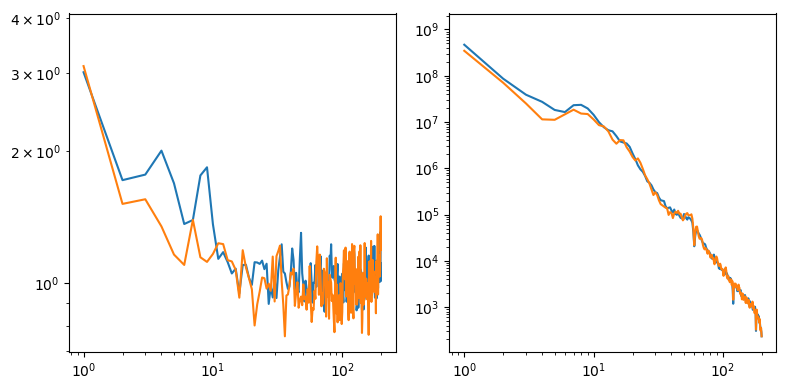

In [5]:
psd = np.squeeze(np.mean(P, axis=2))
scv_0 = np.squeeze(np.std(P[:,:200,np.where(outcome==0)], axis=-1)/np.mean(P[:,:200,np.where(outcome==0)], axis=-1)).T
scv_1 = np.squeeze(np.std(P[:,:200,np.where(outcome==1)], axis=-1)/np.mean(P[:,:200,np.where(outcome==1)], axis=-1)).T
psd_0 = np.squeeze(np.mean(P[:,:200,np.where(outcome==0)], axis=-1)).T
psd_1 = np.squeeze(np.mean(P[:,:200,np.where(outcome==1)], axis=-1)).T
f_axis = f_axis[:200]

print(np.sum(outcome==0))
print(np.sum(outcome==1))

chan = 10
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.loglog(f_axis,scv_0[:,chan])
plt.loglog(f_axis,scv_1[:,chan])
plt.subplot(1,2,2)
plt.loglog(f_axis,psd_0[:,chan])
plt.loglog(f_axis,psd_1[:,chan]);
plt.tight_layout()

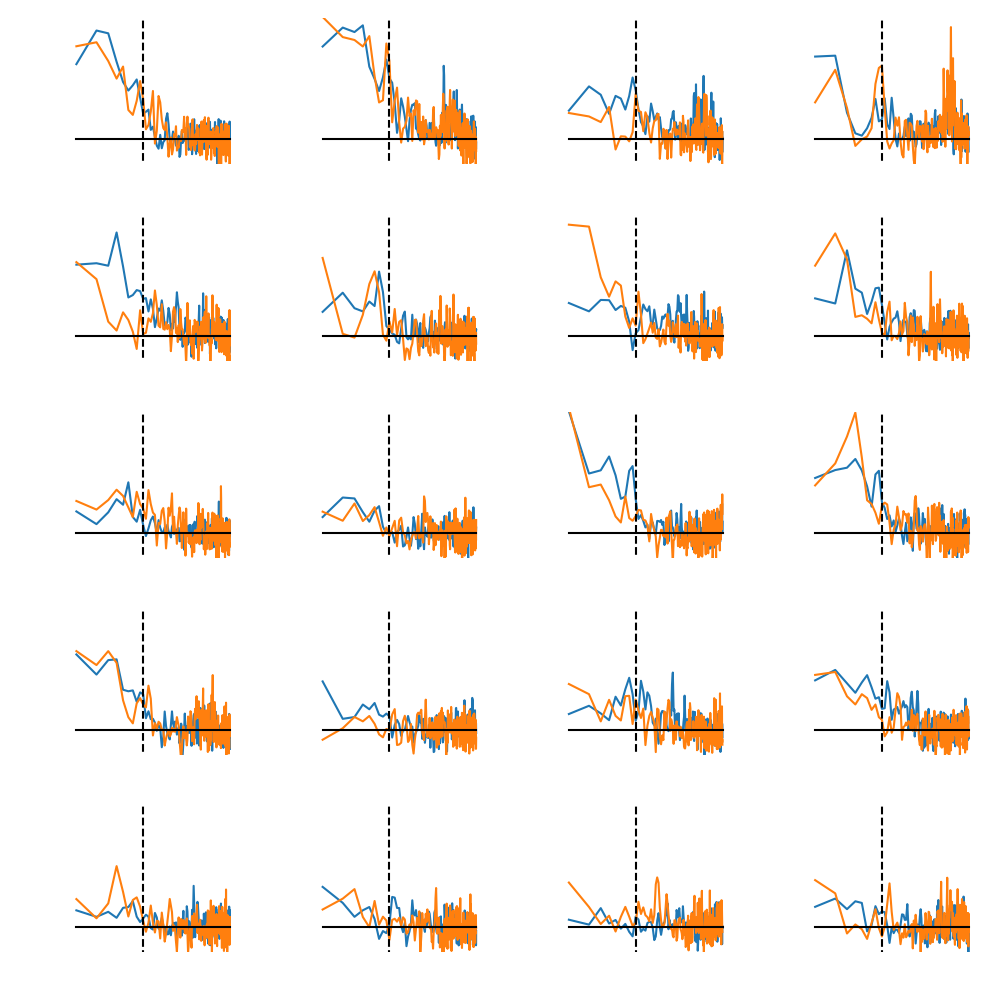

In [6]:
plt.figure(figsize=(10,10))
for chan in range(20):
    plt.subplot(5,4,chan+1)
    plt.loglog(f_axis,scv_0[:,chan])
    plt.loglog(f_axis,scv_1[:,chan])
    plt.plot([1, 200], [1, 1], 'k-')
    plt.plot([10, 10], [0.5, 3], 'k--')
    plt.ylim([0.8, 3])
    plt.axis('off')

plt.tight_layout()

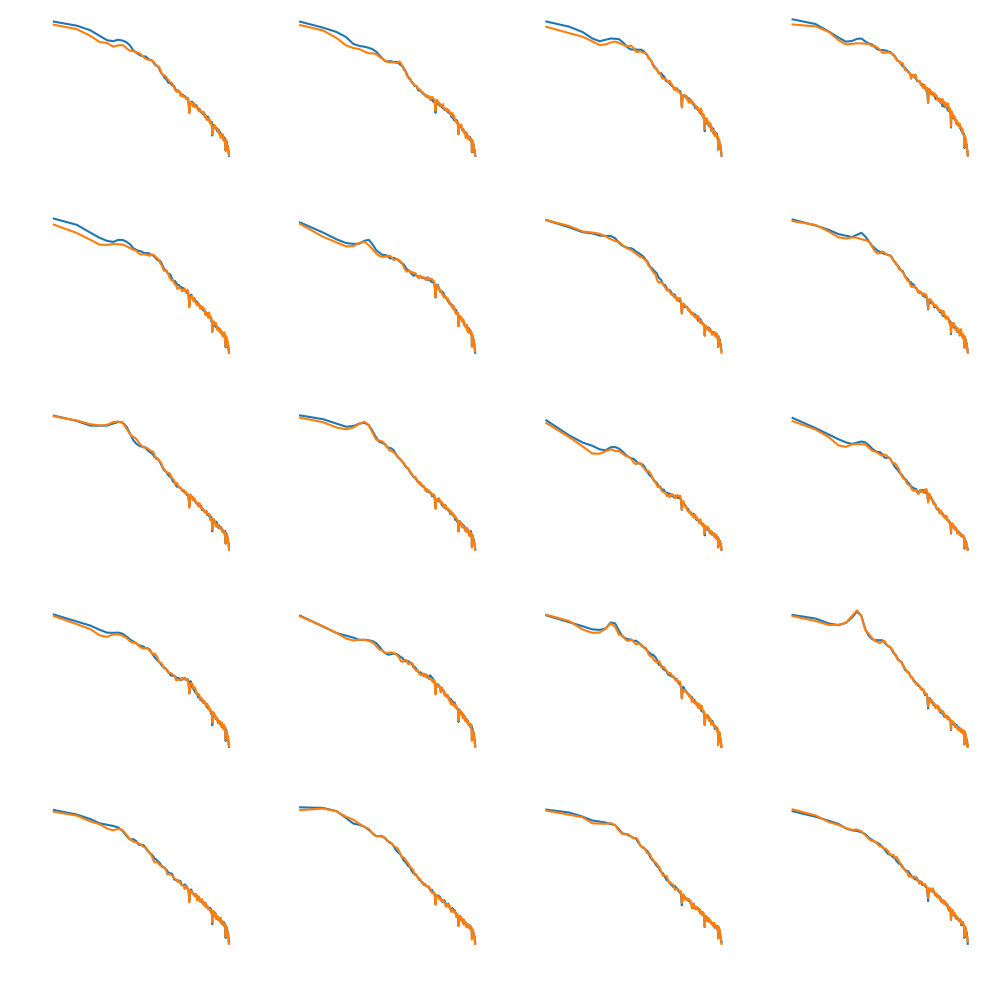

In [7]:
plt.figure(figsize=(10,10))
for chan in range(20):
    plt.subplot(5,4,chan+1)
    plt.loglog(f_axis,psd_0[:,chan])
    plt.loglog(f_axis,psd_1[:,chan])
    plt.axis('off')

plt.tight_layout()

(0.5, 3)

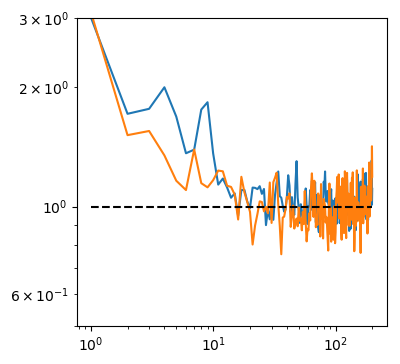

In [8]:
chan = 10
plt.loglog(scv_0[:,chan])
plt.loglog(scv_1[:,chan]);
plt.plot([1,200],[1,1], 'k--')
plt.ylim([0.5, 3])

(1, 200)

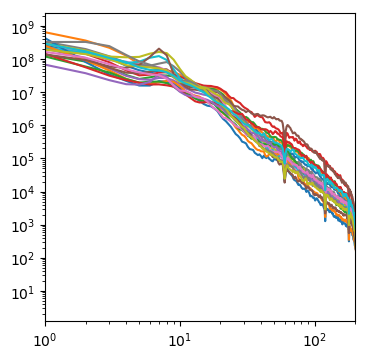

In [302]:
f_axis = np.fft.fftfreq(int(fs), 1/fs)
plt.loglog(f_axis, psd.T);
plt.xlim([1, 200])

### PCA on FTs

data:  (231, 200)
low-d data:  (231, 3)
PCs: (3, 200)


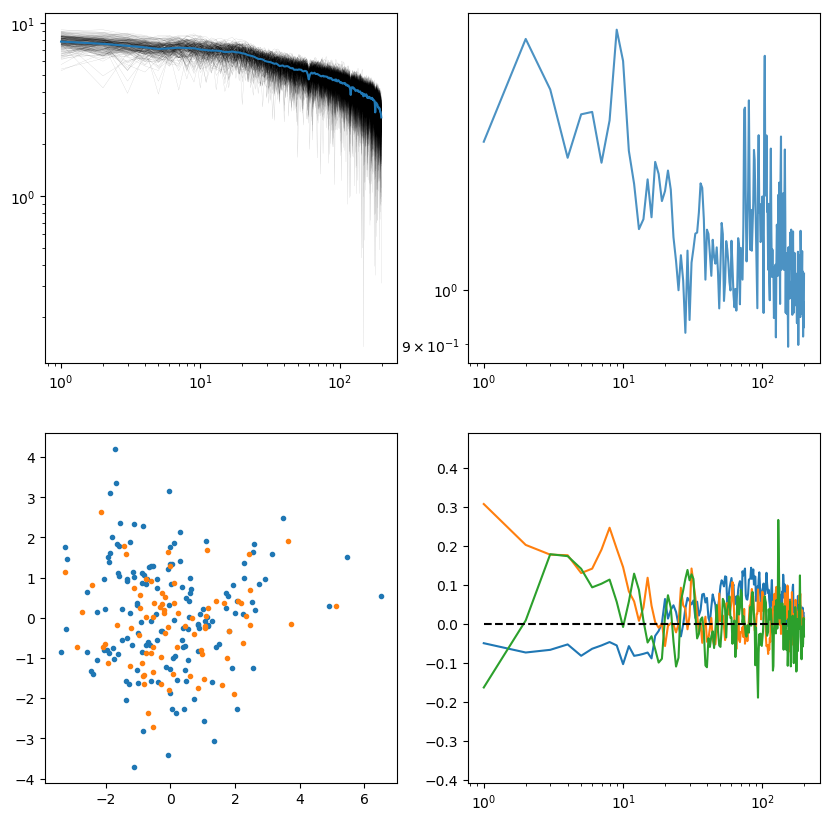

In [314]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
chan = 2
X = np.log10(P[chan,0:200,:]).T
pca.fit(X)

print('data: ', np.shape(X))
print('low-d data: ', np.shape(pca.transform(X)))
print('PCs:', np.shape(pca.components_))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.loglog(X.T, 'k', alpha=0.2, lw=0.2)
plt.loglog(np.mean(X, axis=0))

plt.subplot(2,2,2)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.loglog(np.std(P[chan,:200,:], axis=-1)/np.mean(P[chan,:200,:], axis=-1), alpha=0.8)
# plt.loglog(scv_0[:,chan], alpha=0.8)
# plt.loglog(scv_1[:,chan], alpha=0.8)


plt.subplot(2,2,3)
plt.plot(pca.transform(X)[np.where(outcome==0)[0],0],pca.transform(X)[np.where(outcome==0)[0],1], '.')
plt.plot(pca.transform(X)[np.where(outcome==1)[0],0],pca.transform(X)[np.where(outcome==1)[0],1], '.')
plt.subplot(2,2,4)
plt.semilogx(pca.components_.T);
plt.plot([1, 150], [0,0], 'k--')

### PCA on the transposed spectrogram data (freq by trial)
components in this decomposition transforms the trial vector (for each frequency) 


this makes no sense

data:  (200, 231)
low-d data:  (200, 5)
PCs: (5, 231)


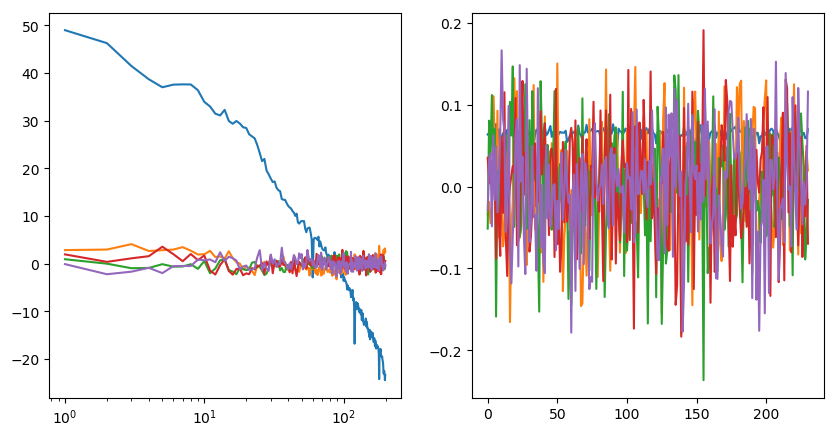

In [225]:
pca = PCA(n_components=5, whiten=False)
chan = 1
X = np.log10(P[chan,:200,:])
pca.fit(X)
print('data: ', np.shape(X))
print('low-d data: ', np.shape(pca.transform(X)))
print('PCs:', np.shape(pca.components_))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.semilogx(pca.transform(X))
#plt.plot(pca.transform(X)[:,0],pca.transform(X)[:,1], '.')
#plt.plot(pca.components_.T)
plt.subplot(1,2,2)
plt.plot(pca.components_.T);

(20, 1600, 231)
(100, 100)


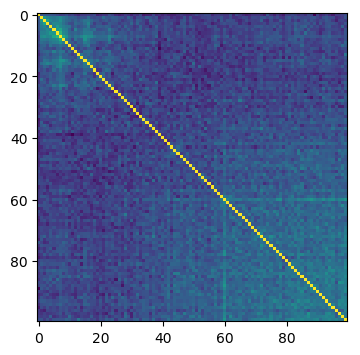

In [239]:
chan=15
print(np.shape(P))
print(np.shape((np.corrcoef(np.log10(P[chan,0:100,:])))))
#plt.imshow(np.log10(P[10,1:100,:]))
plt.imshow(np.corrcoef(np.log10(P[chan,0:100,:])))

### tSNE on spectral data

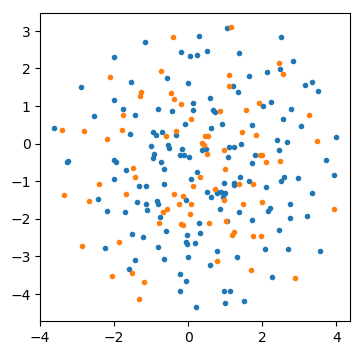

In [321]:
from sklearn.manifold import TSNE
chan = 14
X = np.log10(P[chan,0:200,:]).T
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

# plot
ind0 = np.where(outcome==0)[0]
ind1 = np.where(outcome==1)[0]
plt.plot(X_embedded[ind0,0],X_embedded[ind0,1], '.')
plt.plot(X_embedded[ind1,0],X_embedded[ind1,1], '.')